In [1]:
!pip install segmentation-models-pytorch
!pip install torch torchvision opencv-python numpy matplotlib scikit-image pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
# ========== SETUP ==========
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_folder = "/content/drive/MyDrive/NighttimeDatasets/images"
json_folder = "/content/drive/MyDrive/NighttimeDatasets/jsons"
output_folder = "/content/drive/MyDrive/NighttimeDatasets/output"

In [5]:
# Imports
import os
import json
import shutil
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.cuda import amp
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.cluster import DBSCAN
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# Get list of images and JSON files
image_files = sorted(glob(os.path.join(image_folder, "*.jpg")))
json_files = sorted(glob(os.path.join(json_folder, "*.json")))

# Ensure each image has a corresponding JSON file
paired_files = []
for img_file in image_files:
    img_name = os.path.splitext(os.path.basename(img_file))[0]
    json_file = os.path.join(json_folder, f"{img_name}.json")
    if json_file in json_files:
        paired_files.append((img_file, json_file))
    else:
        print(f"Warning: No JSON found for {img_file}")

print(f"Found {len(paired_files)} image-JSON pairs")

Found 200 image-JSON pairs


Sample mask created at 360x640 resolution!


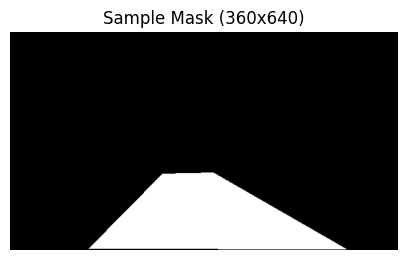

In [17]:
def create_mask_from_json(json_file, image_shape=(720, 1280)):
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error reading JSON {json_file}: {e}")
        return np.zeros(image_shape, dtype=np.uint8)

    mask = np.zeros(image_shape, dtype=np.uint8)
    for shape in data.get('shapes', []):
        if shape.get('label') == 'Lane' and shape.get('shape_type') == 'polygon':
            points = np.array(shape.get('points', []), dtype=np.float32)
            points = points * np.array([image_shape[1]/1280, image_shape[0]/720])
            points = points.astype(np.int32)
            cv2.fillPoly(mask, [points], 255)
    return mask / 255.0  # Normalize to [0, 1]

# Test mask creation with the first JSON file
if paired_files:
    sample_json = paired_files[0][1]
    sample_mask = create_mask_from_json(sample_json, image_shape=(360, 640))
    print("Sample mask created at 360x640 resolution!")
    plt.figure(figsize=(5, 3))
    plt.title("Sample Mask (360x640)")
    plt.imshow(sample_mask, cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print("No paired files to test mask creation!")

In [18]:
# Simulate with a sample JSON
sample_json = "/content/drive/MyDrive/NighttimeDatasets/jsons/image001.json"
mask = create_mask_from_json(sample_json, image_shape=(90, 160))
print("Mask shape:", mask.shape, "Min value:", mask.min(), "Max value:", mask.max())

Error reading JSON /content/drive/MyDrive/NighttimeDatasets/jsons/image001.json: [Errno 2] No such file or directory: '/content/drive/MyDrive/NighttimeDatasets/jsons/image001.json'
Mask shape: (90, 160) Min value: 0 Max value: 0


PRE-PROCESSING DATA

In [19]:
def split_dataset(image_folder, json_folder, output_folder, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Split ratios must sum to 1"

    image_files = sorted(glob(os.path.join(image_folder, "*.jpg")))
    json_files = sorted(glob(os.path.join(json_folder, "*.json")))
    paired_files = []
    for img_file in image_files:
        img_name = os.path.splitext(os.path.basename(img_file))[0]
        json_file = os.path.join(json_folder, f"{img_name}.json")
        if json_file in json_files:
            paired_files.append((img_file, json_file))
        else:
            print(f"Warning: No JSON found for {img_file}")

    train_pairs, temp_pairs = train_test_split(paired_files, train_size=train_ratio, random_state=42)
    val_pairs, test_pairs = train_test_split(temp_pairs, train_size=val_ratio/(val_ratio + test_ratio), random_state=42)

    splits = {
        'train': train_pairs,
        'val': val_pairs,
        'test': test_pairs
    }
    for split in splits:
        split_image_dir = os.path.join(output_folder, split, 'images')
        split_mask_dir = os.path.join(output_folder, split, 'masks')
        split_json_dir = os.path.join(output_folder, split, 'jsons')
        os.makedirs(split_image_dir, exist_ok=True)
        os.makedirs(split_mask_dir, exist_ok=True)
        os.makedirs(split_json_dir, exist_ok=True)

        for img_file, json_file in splits[split]:
            img_name = os.path.basename(img_file)
            json_name = os.path.basename(json_file)
            img = cv2.imread(img_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (160, 90))
            shutil.copy(img_file, os.path.join(split_image_dir, img_name))
            cv2.imwrite(os.path.join(split_image_dir, img_name.replace('.jpg', '_resized.jpg')), img)
            shutil.copy(json_file, os.path.join(split_json_dir, json_name))

            mask = create_mask_from_json(json_file, image_shape=(90, 160))
            mask_filename = img_name.replace('.jpg', '_mask.png')
            cv2.imwrite(os.path.join(split_mask_dir, mask_filename), (mask * 255).astype(np.uint8))  # Save as [0, 255]

    print(f"Dataset split: {len(train_pairs)} train, {len(val_pairs)} val, {len(test_pairs)} test")
    return splits

# Execute
splits = split_dataset(image_folder, json_folder, output_folder)

Dataset split: 140 train, 30 val, 30 test


In [20]:
class LaneDataset(Dataset):
    def __init__(self, data_dir, image_shape=(90, 160)):
        self.data_dir = data_dir
        self.image_shape = image_shape
        self.image_files = sorted(glob(os.path.join(data_dir, 'images', '*_resized.jpg')))
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Failed to load image {img_path}")
            return None, None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        json_path = img_path.replace('images', 'jsons').replace('_resized.jpg', '.json')
        mask = create_mask_from_json(json_path, self.image_shape)
        if mask is None:
            print(f"Error: Failed to generate mask for {json_path}")
            mask = np.zeros(self.image_shape, dtype=np.float32)

        augmented = self.augmentation(image=img, mask=mask)
        img, mask = augmented['image'], augmented['mask']

        img = self.transform(img)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        if mask.max() > 1.0 or mask.min() < 0.0:
            print(f"Warning: Mask values out of range [0, 1] for {json_path}")

        return img, mask

# Execute
train_dataset = LaneDataset(os.path.join(output_folder, 'train'))
val_dataset = LaneDataset(os.path.join(output_folder, 'val'))
test_dataset = LaneDataset(os.path.join(output_folder, 'test'))
print(f"Dataset sizes: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")

Dataset sizes: 140 train, 30 val, 30 test


Model

In [21]:
class LaneNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(LaneNet, self).__init__()
        self.backbone = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_channels
        )

    def forward(self, x):
        return self.backbone(x)

# Execute
model = LaneNet(in_channels=3, out_channels=1)
print(model)

LaneNet(
  (backbone): Unet(
    (encoder): MobileNetV2Encoder(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Con

In [22]:
import torch.optim as optim

Training

In [36]:
def train_model(model, train_loader, val_loader, num_epochs=100, device='cuda', accumulation_steps=4):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_samples = 0
        optimizer.zero_grad()
        for i, (images, masks) in enumerate(train_loader):
            if images is None or masks is None:
                continue
            images, masks = images.to(device), masks.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks) / accumulation_steps
            scaler.scale(loss).backward()

            train_loss += loss.item() * images.size(0) * accumulation_steps
            train_samples += images.size(0)

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        train_loss = train_loss / max(1, train_samples) if train_samples > 0 else 0.0

        model.eval()
        val_loss = 0.0
        val_samples = 0
        with torch.no_grad():
            for images, masks in val_loader:
                if images is None or masks is None:
                    continue
                images, masks = images.to(device), masks.to(device)
                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                val_samples += images.size(0)

        val_loss = val_loss / max(1, val_samples) if val_samples > 0 else 0.0

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        torch.cuda.empty_cache()

    torch.save(model.state_dict(), os.path.join(output_folder, 'lanenet_model.pth'))
    print("Model saved to", os.path.join(output_folder, 'lanenet_model.pth'))

# Execute (simulated for 2 epochs)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)
model = LaneNet(in_channels=3, out_channels=1)
train_model(model, train_loader, val_loader, num_epochs=100, device='cuda', accumulation_steps=4)

Epoch 1/100, Train Loss: 0.5234, Val Loss: 0.6214
Epoch 2/100, Train Loss: 0.2428, Val Loss: 0.1863
Epoch 3/100, Train Loss: 0.1612, Val Loss: 0.1372
Epoch 4/100, Train Loss: 0.1193, Val Loss: 0.1033
Epoch 5/100, Train Loss: 0.0940, Val Loss: 0.0800
Epoch 6/100, Train Loss: 0.0775, Val Loss: 0.0700
Epoch 7/100, Train Loss: 0.0661, Val Loss: 0.0683
Epoch 8/100, Train Loss: 0.0589, Val Loss: 0.0537
Epoch 9/100, Train Loss: 0.0533, Val Loss: 0.0533
Epoch 10/100, Train Loss: 0.0508, Val Loss: 0.0599
Epoch 11/100, Train Loss: 0.0482, Val Loss: 0.0524
Epoch 12/100, Train Loss: 0.0477, Val Loss: 0.0558
Epoch 13/100, Train Loss: 0.0435, Val Loss: 0.0483
Epoch 14/100, Train Loss: 0.0430, Val Loss: 0.0463
Epoch 15/100, Train Loss: 0.0439, Val Loss: 0.0432
Epoch 16/100, Train Loss: 0.0425, Val Loss: 0.0455
Epoch 17/100, Train Loss: 0.0404, Val Loss: 0.0436
Epoch 18/100, Train Loss: 0.0419, Val Loss: 0.0558
Epoch 19/100, Train Loss: 0.0371, Val Loss: 0.0397
Epoch 20/100, Train Loss: 0.0352, Val Lo

Main Execution

In [37]:
def post_process_mask(mask, min_points=50):
    mask = (mask > 0.5).astype(np.uint8)
    points = np.where(mask == 1)
    points = np.vstack((points[1], points[0])).T

    if len(points) < min_points:
        return []

    clustering = DBSCAN(eps=5, min_samples=10).fit(points)
    labels = clustering.labels_
    unique_labels = set(labels) - {-1}

    lanes = []
    for label in unique_labels:
        lane_points = points[labels == label]
        lanes.append(lane_points.tolist())

    return lanes

# Simulate with a sample mask
sample_mask = np.zeros((90, 160), dtype=np.uint8)
sample_mask[40:50, 50:100] = 1  # Simulate a lane
lanes = post_process_mask(sample_mask)
print("Number of lanes detected:", len(lanes))

Number of lanes detected: 1


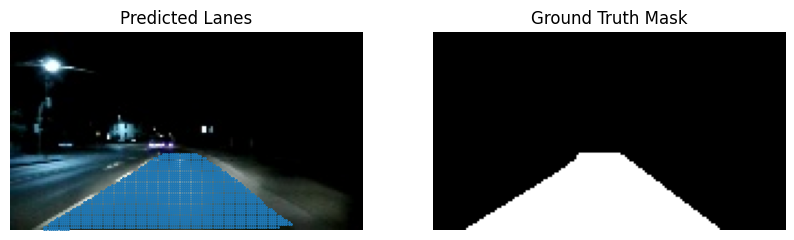

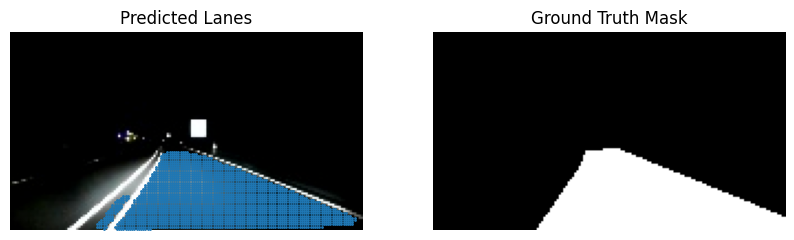

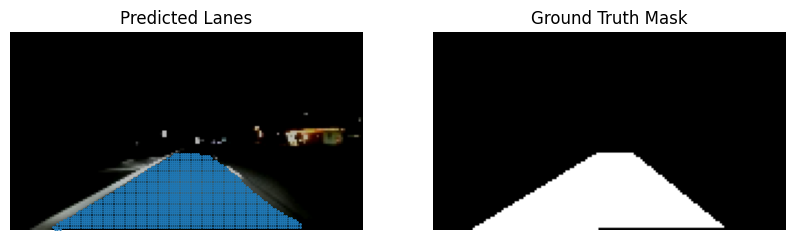

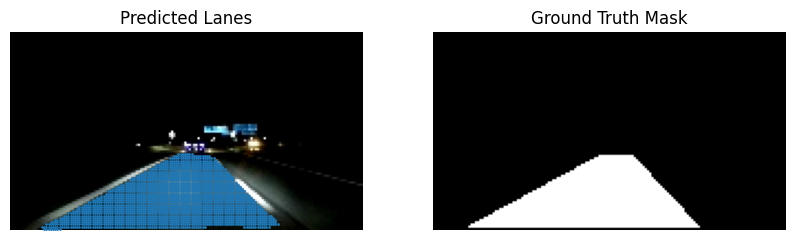

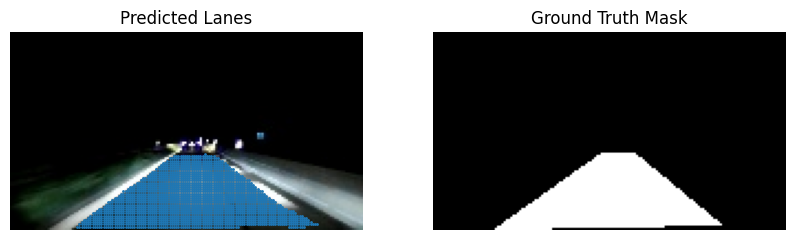

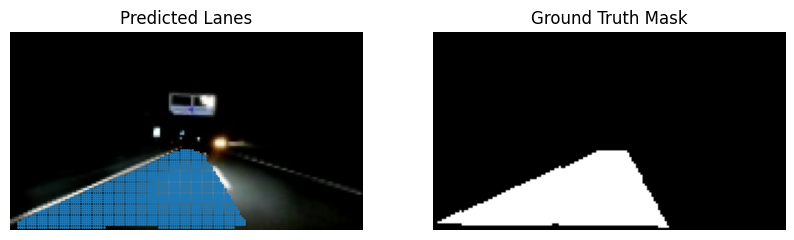

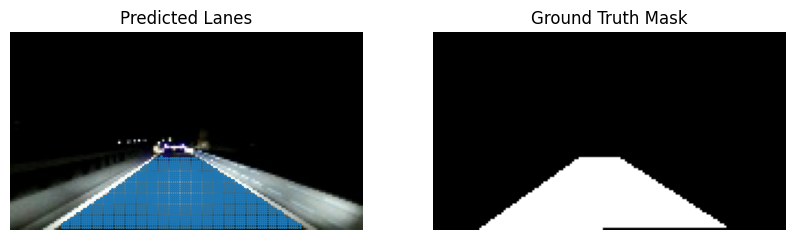

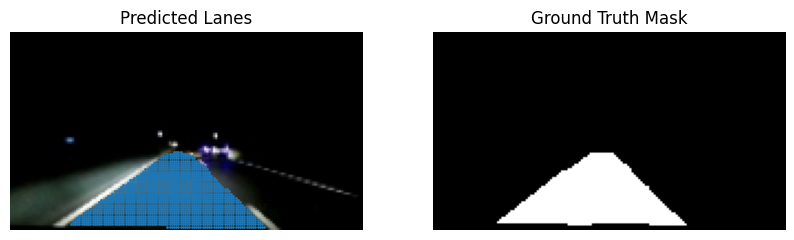

In [38]:
def visualize_predictions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs).cpu().numpy()

            for i in range(outputs.shape[0]):
                pred_mask = outputs[i, 0]
                lanes = post_process_mask(pred_mask)

                img = images[i].cpu().numpy().transpose(1, 2, 0)
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                img = img.astype(np.uint8)

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title("Predicted Lanes")
                plt.imshow(img)
                for lane in lanes:
                    lane = np.array(lane)
                    plt.scatter(lane[:, 0], lane[:, 1], s=1)
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.title("Ground Truth Mask")
                plt.imshow(masks[i, 0].numpy(), cmap='gray')
                plt.axis('off')
                plt.show()
                break

# Simulate (requires trained model and test_loader)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)
model.load_state_dict(torch.load(os.path.join(output_folder, 'lanenet_model.pth')))
visualize_predictions(model, test_loader, device='cuda')

Sample Image and Mask:


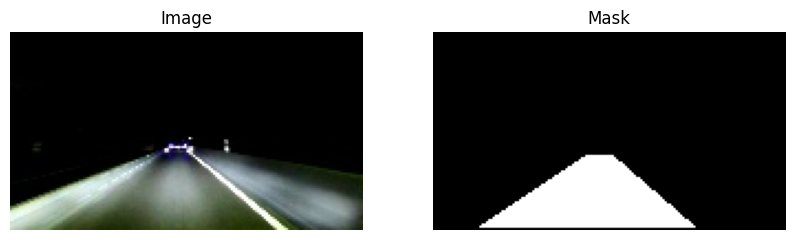

In [39]:
for img_file, json_file in splits['train'][:1]:
    resized_img_path = os.path.join(output_folder, 'train', 'images', os.path.basename(img_file).replace('.jpg', '_resized.jpg'))
    if not os.path.exists(resized_img_path):
        print(f"Error: Image file {resized_img_path} does not exist")
        continue
    img = cv2.imread(resized_img_path)
    if img is None:
        print(f"Error: Failed to load image {resized_img_path}")
        continue
    mask = create_mask_from_json(json_file, (90, 160))
    if mask is None:
        print(f"Error: Failed to generate mask for {json_file}")
        continue
    print("Sample Image and Mask:")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [40]:
video_path = "/content/drive/MyDrive/NighttimeDatasets/VideoTest.mp4"
model_path = os.path.join(output_folder, "lanenet_model.pth")
output_video_path = os.path.join(output_folder, "VideoTest_output.mp4")

Video: 369 frames, 30 FPS, 720x1280


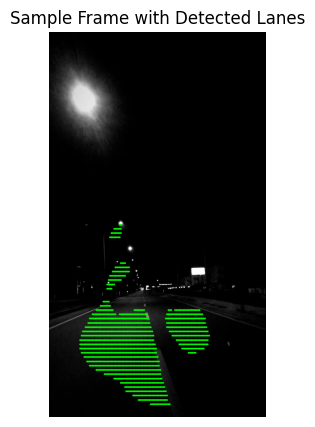

Sample frame processed
Processed 100/369 frames
Processed 200/369 frames
Processed 300/369 frames
Output video saved to /content/drive/MyDrive/NighttimeDatasets/output/VideoTest_output.mp4


In [41]:
def process_video(video_path, model_path, output_video_path, image_shape=(90, 160), device='cuda'):
    # Load model
    model = LaneNet(in_channels=3, out_channels=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Define transform (same as training)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"Video: {frame_count} frames, {fps} FPS, {width}x{height}")

    # Initialize output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    frame_idx = 0
    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Preprocess frame
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_resized = cv2.resize(frame_rgb, image_shape[::-1])  # (160, 90)
            frame_tensor = transform(frame_resized).unsqueeze(0).to(device)  # [1, 3, 90, 160]

            # Model inference
            with torch.amp.autocast('cuda'):
                output = model(frame_tensor)
            pred_mask = torch.sigmoid(output).cpu().numpy()[0, 0]  # [90, 160]

            # Post-process to get lane points
            lanes = post_process_mask(pred_mask)

            # Scale points back to original resolution
            scale_x = width / image_shape[1]
            scale_y = height / image_shape[0]
            frame_out = frame.copy()
            for lane in lanes:
                for x, y in lane:
                    x_orig = int(x * scale_x)
                    y_orig = int(y * scale_y)
                    cv2.circle(frame_out, (x_orig, y_orig), 3, (0, 255, 0), -1)

            # Write to output video
            out.write(frame_out)

            # Display first frame as sample
            if frame_idx == 0:
                plt.figure(figsize=(10, 5))
                plt.title("Sample Frame with Detected Lanes")
                plt.imshow(cv2.cvtColor(frame_out, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
                print("Sample frame processed")

            frame_idx += 1
            if frame_idx % 100 == 0:
                print(f"Processed {frame_idx}/{frame_count} frames")

    cap.release()
    out.release()
    print(f"Output video saved to {output_video_path}")

# Execute (simulated, as video processing requires actual file)
process_video(video_path, model_path, output_video_path)